<a href="https://colab.research.google.com/github/slv-ai/sentimental-analysis-LSTM/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter sentiment analysis using LSTM

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
import re



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,GlobalMaxPool1D,SpatialDropout1D

In [ ]:
train=pd.read_csv('twitter_training.csv')
val=pd.read_csv('twitter_validation.csv')

In [ ]:
train.shape

(74681, 4)

In [ ]:
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
train.columns=['id','entity','sentiment','content']
train.head()
train.shape

(74681, 4)

In [ ]:
train.entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
train.sentiment.value_counts()

Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

In [ ]:
train.isnull().sum()

id             0
entity         0
sentiment      0
content      686
dtype: int64

In [ ]:
train.dropna(axis=0,inplace=True)

In [ ]:
train.isnull().sum()

id           0
entity       0
sentiment    0
content      0
dtype: int64

In [ ]:
train.head()


,id,entity,sentiment,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


<Axes: xlabel='sentiment'>

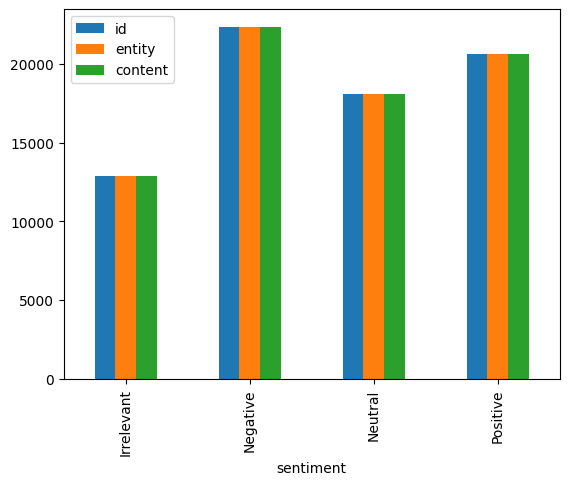

In [ ]:
train.groupby('sentiment').count().plot(kind='bar')

Text Preprocessing

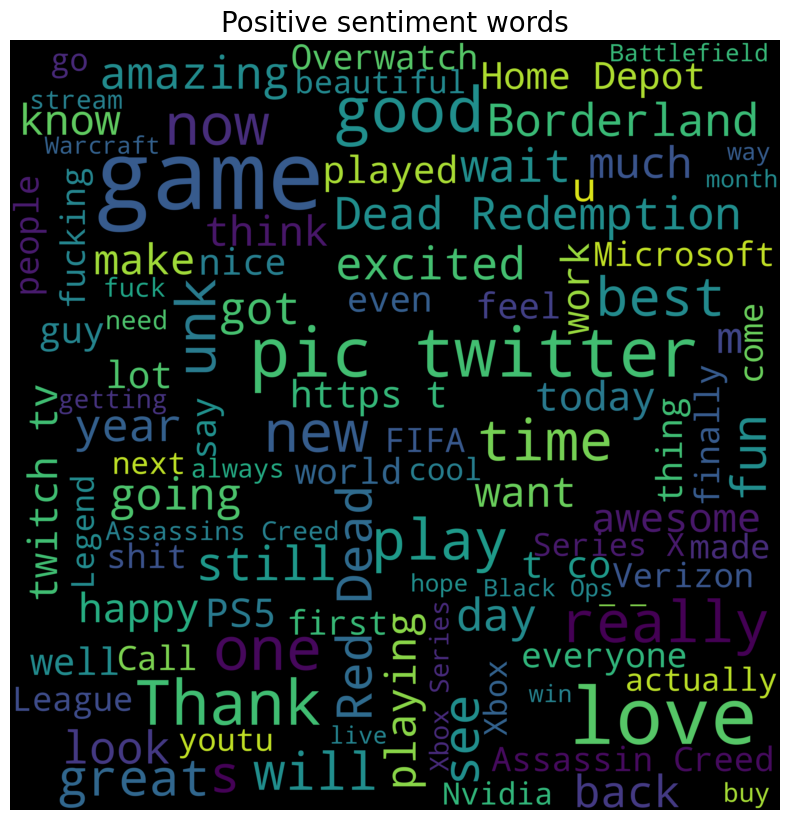

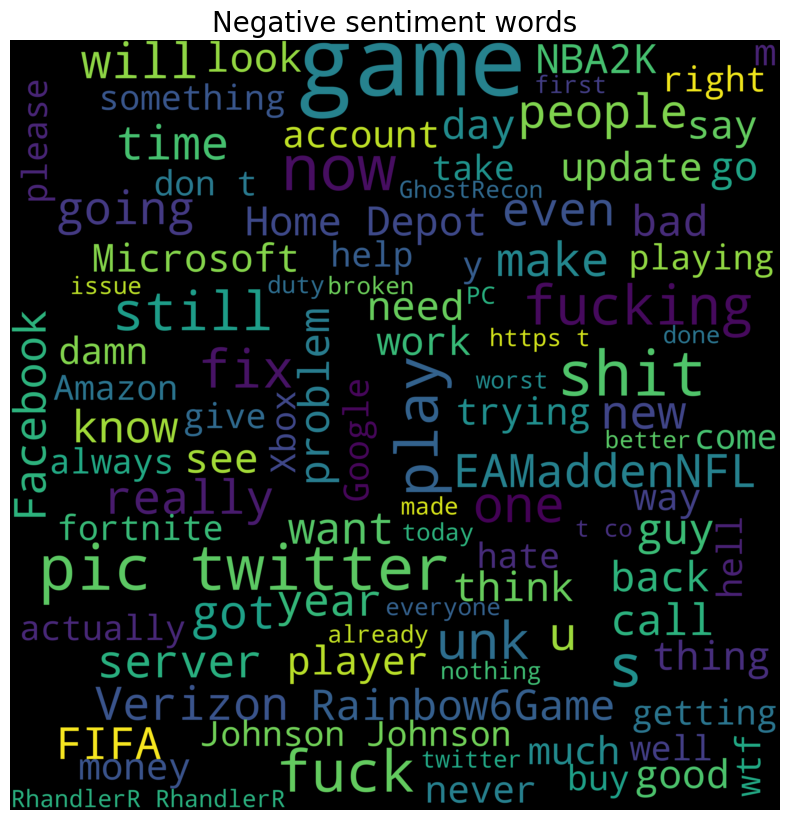

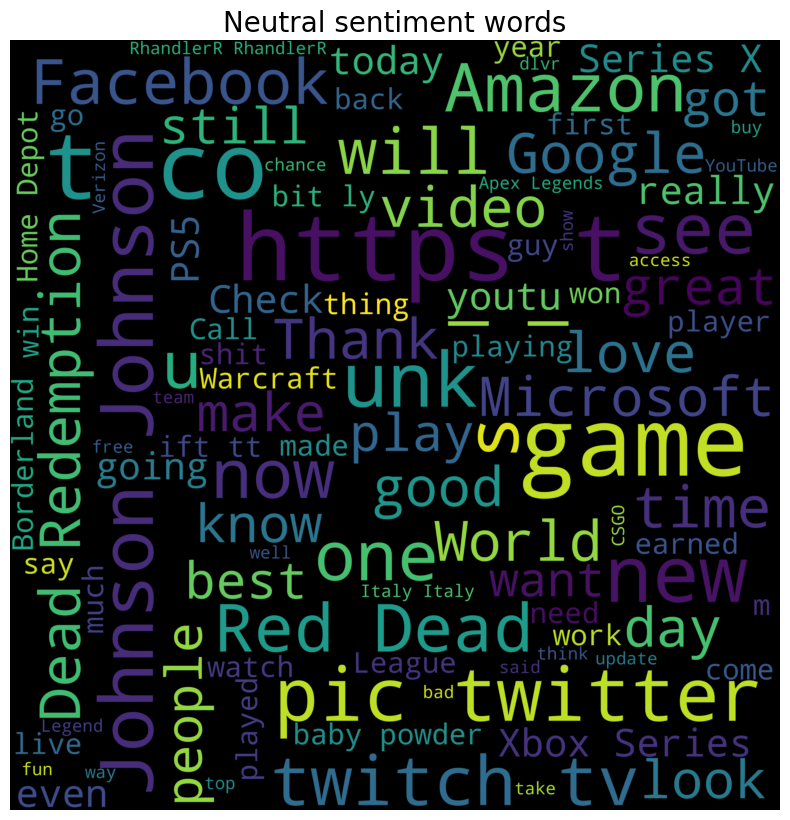

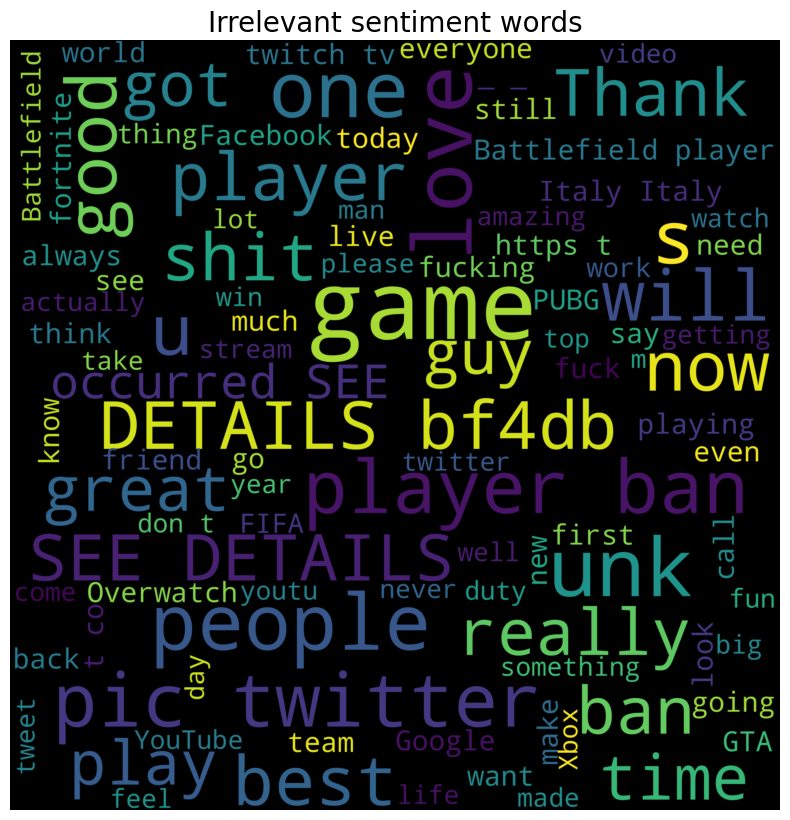

In [ ]:
from wordcloud import WordCloud , STOPWORDS


def word_cloud_text(train,sentiment):
  combined_content=" ".join([tweet for tweet in train [train.sentiment == sentiment]['content']])
  wordcloud=WordCloud(max_font_size=100,max_words=100,background_color="black",scale=10,width=800,height=800,stopwords=STOPWORDS)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud.generate(combined_content),interpolation="bilinear")
  plt.title('{} sentiment words'.format(sentiment),fontsize=20)
  plt.axis("off")
  plt.show()

word_cloud_text(train,'Positive')

word_cloud_text(train,'Negative')

word_cloud_text(train,'Neutral')

word_cloud_text(train,'Irrelevant')

In [ ]:
train.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
replace_list={r"im" : 'i am' ,
              r"'re" : 'are' ,
              r"let's" : 'let us',
              r"'s" : 'is' ,
              r" 've" : 'have',
              r"can't" :'can not',
              r"shan't" : 'shall not',
              r"n't" : 'not',
              r"'d" : 'would',
              r"'ll" : 'will',
              r"'scuse" : 'excuse'
              }
def clean_text(text):
  text=text.lower()
  for s in replace_list:
    text=text.replace(s,replace_list[s])
  text=' '.join(text.split())
  return text

In [ ]:
x=train['content'].apply(lambda p :clean_text(p))

In [ ]:
x[20]

'that was the first borderlands session in a long ti ame where i actually enjoyed a really satisfying combat experience. i got some rather good kills'

max content length :198


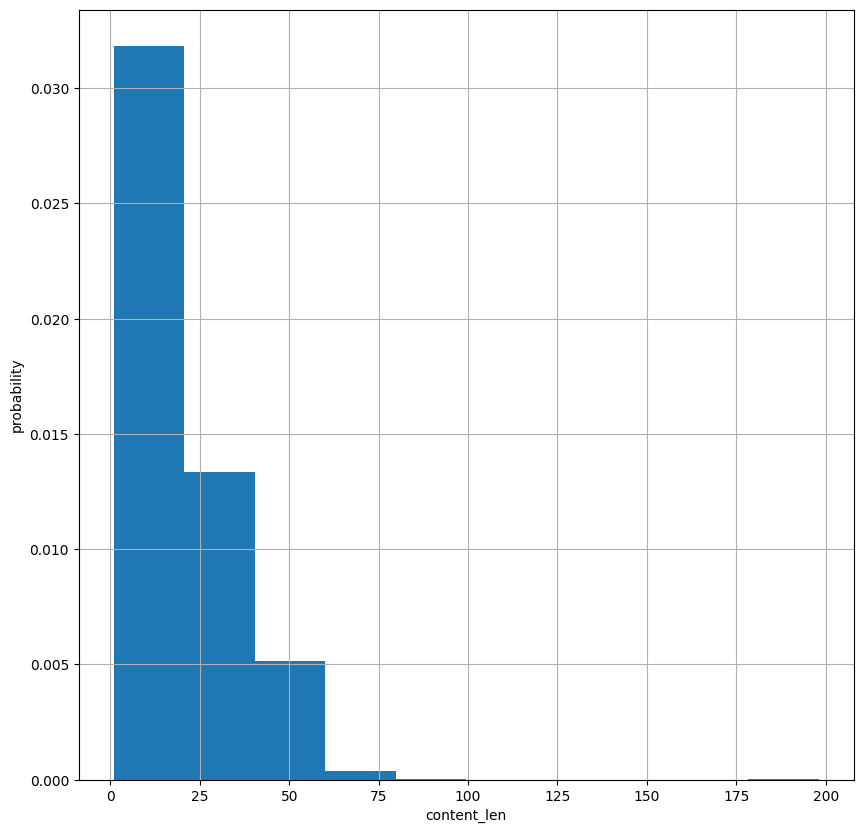

In [ ]:
content_len=x.apply(lambda p:len(p.split(' ')))
max_contentlength=content_len.max()
print("max content length :{0}".format(max_contentlength))
plt.figure(figsize=(10,10))
plt.hist(content_len,density=True)
plt.xlabel("content_len")
plt.ylabel("probability")
plt.grid()

In [ ]:
def content_words(tweet):
  #convert text into sequence of words
  #convert to lowercase
  text1=tweet.lower()
  #remove non letters
  text1=re.sub(r"[^a-zA-Z0-9]"," ",text1)
  #tokenize
  words=text1.split()
  #remove stop words
  words=[w for w in words if w not in stopwords.words("english")]
  #stemming
  words=[PorterStemmer().stem(w)for w in words]
  return words
print("\n original content",train['content'][0])
print("\n processed content",content_words(train['content'][0]))



 original content I am coming to the borders and I will kill you all,

 processed content ['come', 'border', 'kill']


In [ ]:
#apply data processing to each content
X=list(map(content_words,train['content']))
Y=train['sentiment']

In [ ]:
max_words=190
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X)
x = tokenizer.texts_to_sequences(X)
x = pad_sequences(x, maxlen = 190)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(Y)

y = np.array(label_tokenizer.texts_to_sequences(Y))

Training a model

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8)


In [ ]:
model_lstm=Sequential()
model_lstm.add(Embedding(input_dim=max_words,output_dim=128,input_length=190))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128,dropout=0.3,recurrent_dropout=0.3))
model_lstm.add(Dense(128,activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5,activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
history=model_lstm.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=512)

Epoch 1/10
116/116 [==============================] - 458s 4s/step - loss: 1.3061 - accuracy: 0.3988 - val_loss: 1.1741 - val_accuracy: 0.4896
Epoch 2/10
116/116 [==============================] - 450s 4s/step - loss: 1.1520 - accuracy: 0.4971 - val_loss: 1.1258 - val_accuracy: 0.4996
Epoch 3/10
116/116 [==============================] - 456s 4s/step - loss: 1.1296 - accuracy: 0.5064 - val_loss: 1.1129 - val_accuracy: 0.5080
Epoch 4/10
116/116 [==============================] - 454s 4s/step - loss: 1.1184 - accuracy: 0.5098 - val_loss: 1.1074 - val_accuracy: 0.5094
Epoch 5/10
116/116 [==============================] - 456s 4s/step - loss: 1.1108 - accuracy: 0.5142 - val_loss: 1.1019 - val_accuracy: 0.5106
Epoch 6/10
116/116 [==============================] - 440s 4s/step - loss: 1.1035 - accuracy: 0.5144 - val_loss: 1.0957 - val_accuracy: 0.5162
Epoch 7/10
116/116 [==============================] - 441s 4s/step - loss: 1.0962 - accuracy: 0.5188 - val_loss: 1.0927 - val_accuracy: 0.5140

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 190, 128)          24320     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 190, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                      

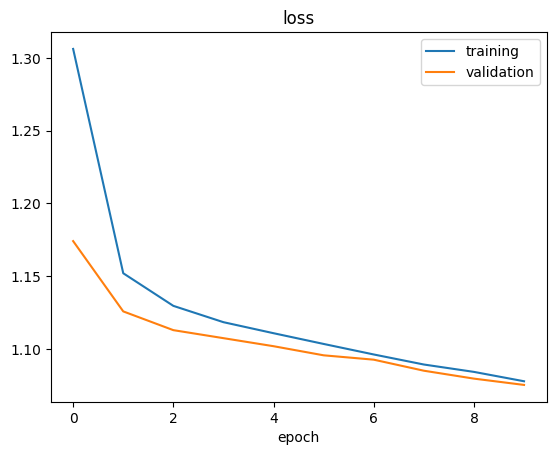

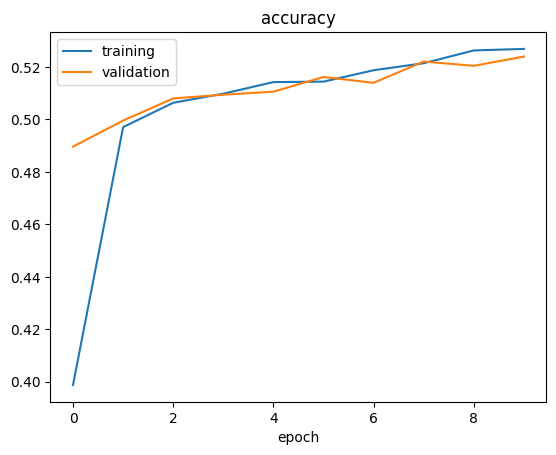

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()
